In [1]:
# Import packages.
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()
from datetime import datetime, timezone, timedelta
from dateutil.relativedelta import relativedelta
import scipy.stats as stats
import matplotlib.pylab as pylab
import glob
import os
from numpy.random import seed
from scipy.stats import gamma
import pymc3 as pm

In [2]:
# Plotting defaults
params = {'legend.fontsize': 15,
         'axes.labelsize': 15,
         'axes.titlesize':20,
         'xtick.labelsize':'large',
         'ytick.labelsize':'large',
         'legend.title_fontsize': 15
         }
pylab.rcParams.update(params)

In [3]:
# Prior notebook ends with a csv save of train_master dataset.
train_csv = "../train_master.csv"
dates = ['TIME_SCHEDULED',
         'ARRIVAL',
         'DEPARTURE',
         'Date',
         'SURVEY_DATE_EFFECTIVE',
         'BRONCOS_TIME']
trains = pd.read_csv(train_csv,
                    header=0,
                     sep=',',
                     index_col=0,
                     infer_datetime_format=True,
                     parse_dates=dates)
trains.info(verbose=True, null_counts=True)

C:\Users\jsummer\AppData\Local\Continuum\anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3063: DtypeWarning: Columns (49,50,51,52,53,54,55,56,57,75) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)
C:\Users\jsummer\AppData\Local\Continuum\anaconda3\lib\site-packages\numpy\lib\arraysetops.py:569: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


<class 'pandas.core.frame.DataFrame'>
Int64Index: 1843234 entries, 0 to 1843233
Data columns (total 103 columns):
 #   Column                                Non-Null Count    Dtype         
---  ------                                --------------    -----         
 0   SERIAL_NUMBER                         1843234 non-null  int64         
 1   SCHEDULE_NAME                         1843234 non-null  object        
 2   SIGNUP_NAME                           1843234 non-null  object        
 3   SURVEY_SOURCE                         1843234 non-null  int64         
 4   PATTERN_ID                            1843234 non-null  int64         
 5   BRANCH                                1843234 non-null  object        
 6   ROUTE_NUMBER                          1843234 non-null  int64         
 7   ROUTE_NAME                            1843234 non-null  object        
 8   DIRECTION_NAME                        1843234 non-null  object        
 9   SERVICE_TYPE                          1843234

# Evaluate Difference of Mean Delays between 'Good Weather' and "Bad Weather"

In [4]:
# Define good weather as departures wherein Snow and Hail/Ice were not present.
snow_ice_delays = trains['DEPARTURE_DELAY'].loc[(trains['Light Freezing Drizzle/Freezing Rain']==1) | 
                                                    (trains['Light Snow']==1) | 
                                                    (trains['Snow'] == 1) |
                                                    (trains['Heavy Snow'] == 1) |
                                                    (trains['Blowing Or Drifting Snow']==1) |
                                                    (trains['Freezing Drizzle/Freezing Rain']==1) | 
                                                    (trains['Light Freezing Rain']==1) | 
                                                    (trains['Hail Showers'] == 1)]
good_weather_delays = trains['DEPARTURE_DELAY'].loc[(trains['Light Freezing Drizzle/Freezing Rain']==0) &
                                                    (trains['Light Snow']==0) & 
                                                    (trains['Snow'] == 0) &
                                                    (trains['Heavy Snow'] == 0) &
                                                    (trains['Blowing Or Drifting Snow'] ==0) &
                                                    (trains['Freezing Drizzle/Freezing Rain'] ==0) & 
                                                    (trains['Light Freezing Rain'] ==0) & 
                                                    (trains['Hail Showers'] == 0)]

In [5]:
def bootstrap_replicate(data, func,size=1):
    """Draw bootstrap samples of equal length of data and create a distribution of bootstrap mean replicates."""
    bs_replicates = np.empty(size)
    for i in range(size):
        bs_replicates[i] = func(np.random.choice(data,size=len(data)))
    return bs_replicates

In [6]:
# Create mean bootstrap replicates of each subsection of delays.
np.random.seed(13)
good_weather_replicates = bootstrap_replicate(good_weather_delays,np.mean,50000)
snow_ice_replicates = bootstrap_replicate(snow_ice_delays,np.mean,50000)

In [7]:
# Gather a bootstrapped difference of means and its resulting confidence interval
diff_of_means = snow_ice_replicates - good_weather_replicates
CI = np.percentile(diff_of_means,[2.5,97.5])
print("95% Confidence Interval: "+str(CI))

95% Confidence Interval: [35.82728009 39.10296803]


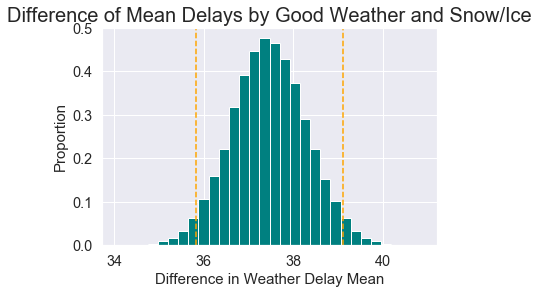

In [8]:
# Plot the difference of bootstrapped means with a 95% confidence interval.
_ = plt.hist(diff_of_means, density=True, bins=30,color='teal')
_ = plt.title('Difference of Mean Delays by Good Weather and Snow/Ice')
_ = plt.xlabel('Difference in Weather Delay Mean')
_ = plt.ylabel('Proportion')
_ = plt.axvline(x=CI[0], c='orange', linestyle='--')
_ = plt.axvline(x=CI[1], c='orange', linestyle='--')
plt.show()

Since the 95% confidence interval does not near 0, snow/icy departures are delayed more than non-snowy/icy days.

# Compare Southbound train delays with other other directions

In [9]:
def permutation_samples(data1, data2):
    """Generate 2 permutated samples from 2 provided arrays."""
    
    # Concatenate datasets
    combined = np.concatenate((data1, data2))
    # Permute combined dataset
    permuted_combined = np.random.permutation(combined)
    # Create 2 randomized samples for comparison
    perm_1 = permuted_combined[:len(data1)]
    perm_2 = permuted_combined[len(data1):]
    
    return perm_1, perm_2

def permutation_replicates(data1, data2, func, size=1):
    """Generate permutated replicates"""
    
    # Create empty array for replicate values
    replicates = np.empty(size)
    
    for i in range(size):
        # Generate permutation samples using permutation_samples function
        sample_1, sample_2 = permutation_samples(data1, data2)
        
        # Compute replicates using provided func
        replicates[i] = func(sample_1, sample_2)
    
    return replicates

def diff_of_means(data1, data2):
    """Generate difference in function of 2 arrays."""
    
    diff = np.mean(data1) - np.mean(data2)
    return diff

In [10]:
# Create array of delays for southbound and non-southbound trains
south = trains['DEPARTURE_DELAY'].loc[trains.DIRECTION_NAME == 'south']
other_directions = trains['DEPARTURE_DELAY'].loc[trains.DIRECTION_NAME != 'south']

# Create bootstrap replicates of differences of means
bs_diff = permutation_replicates(south, other_directions,diff_of_means,size=10000)
emp_diff = diff_of_means(south,other_directions)

p_value = np.sum(bs_diff >= emp_diff)/len(bs_diff)

print(p_value)

0.0


P-value of 0 indicates that a null hypothesis of southbound trains have equal average delays to other directions should be rejected and alternative hypothesis accepted.

# Evaluate and attempt to simulate delays departure distribution

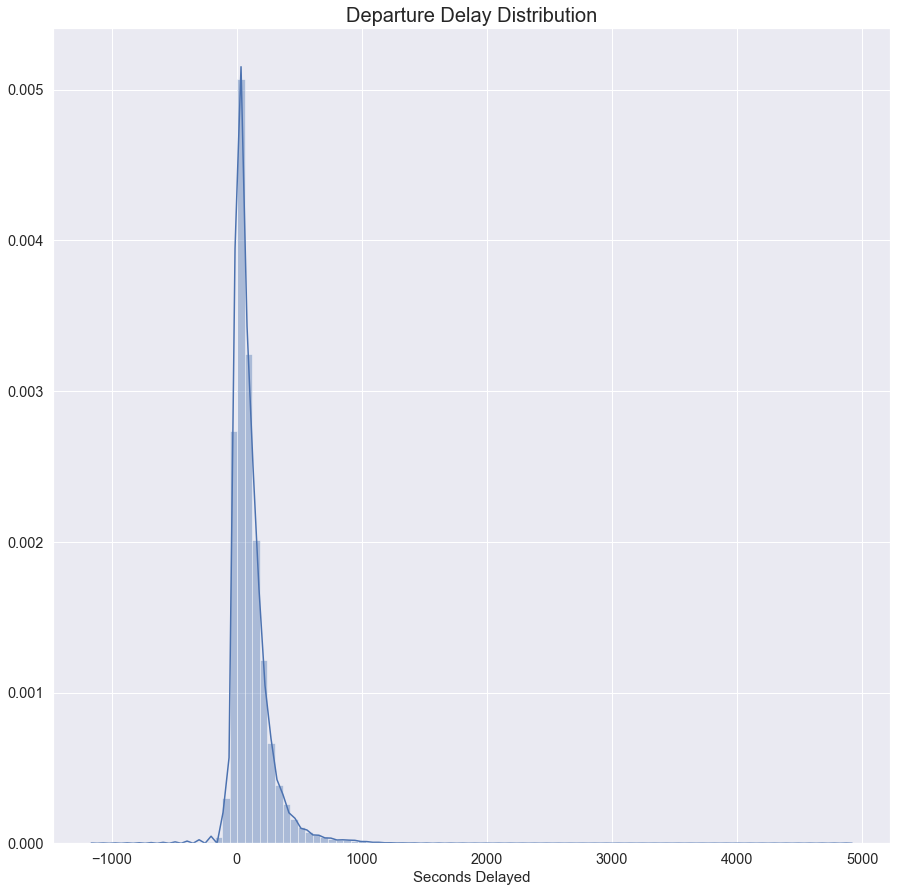

In [11]:
# Evaluate distribution of delays. Could the distribution be exponential and defined by an alpha and beta?
plt.figure(figsize=(15,15))
sns.distplot(trains['DEPARTURE_DELAY'],
            bins = 100,
            hist=True,
            norm_hist=True)
plt.xlabel('Seconds Delayed')
plt.title('Departure Delay Distribution')
plt.show()

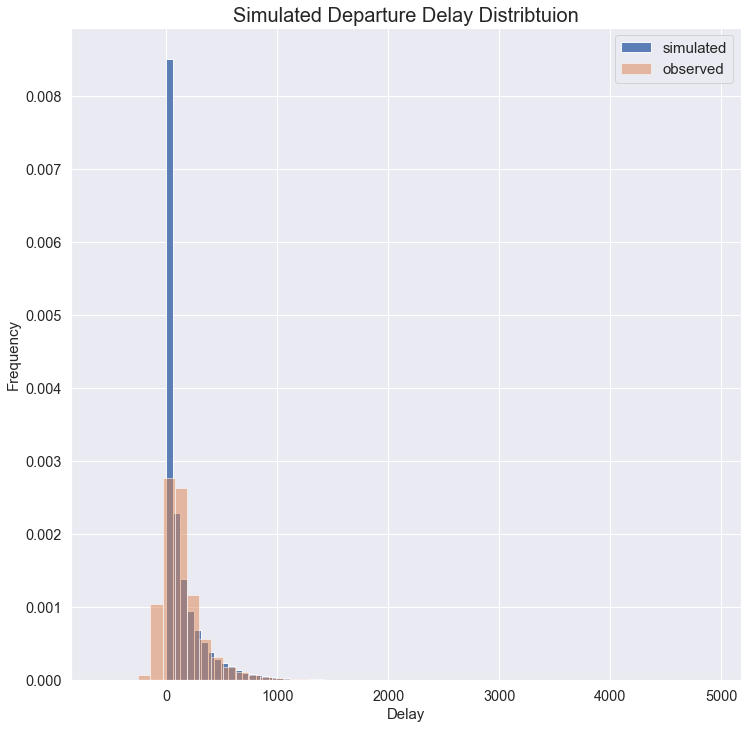

In [12]:
delays = trains['DEPARTURE_DELAY'].loc[trains['END_OF_LINE']==1]
n_delays = len(delays)

alpha_est = np.mean(delays)**2 / np.var(delays)
beta_est = np.var(delays) / np.mean(delays)
alpha_est, beta_est

simulated = gamma(alpha_est, scale=beta_est).rvs(n_delays)

plt.figure(figsize=(12,12))
_ = plt.hist(simulated, bins=50, alpha=0.9, label='simulated', density=True)
_ = plt.hist(delays, bins=50, alpha=0.5, label='observed',density=True)
_ = plt.xlabel('Delay')
_ = plt.ylabel('Frequency')
_ = plt.title('Simulated Departure Delay Distribtuion')
_ = plt.legend()